In [24]:
using Preferences, BenchmarkTools, Plots
using LinearAlgebra, PreallocationTools, ForwardDiff, DiffResults

In [5]:
const nₓ = 128
const Δx = 2π/nₓ
const Δt = 0.1
const rank = 2

# preallocations
x_new = zeros(nₓ)
y_new = zeros(nₓ)

# set initial condition
x = Array(range(0., 2π - Δx, nₓ))
y = sin.(x)
Ψ = rand(nₓ, rank)

# preallocated caches that support ForwardDiff:
struct burger_app
    x_d::DiffCache
    y_d::DiffCache
end
burger = burger_app(
    DiffCache(x_new),
    DiffCache(y_new),
);

In [6]:
function interp_periodic(coord, f)
    bound = nₓ
    # r, i = modf(coord / Δx)
    scaled = coord / Δx
    i = trunc(scaled)
    r = scaled - i
    i = mod1(Int(i+1), bound)
    (1 - r)*f[i] + r*f[mod1(i+1, bound)]
end

function semi_lagrangian(burger::burger_app, y, Δt)
    # load preallocated arrays from caches 
    # (loads normal data for y::Real, diffcache for y::Dual)
    x_back = get_tmp(burger.x_d, y)
    y_intp = get_tmp(burger.y_d, y)

    x_back .= x .- Δt * y
    y_intp .= interp_periodic.(x_back, Ref(y))
    y .= y_intp
    return y
end

semi_lagrangian (generic function with 1 method)

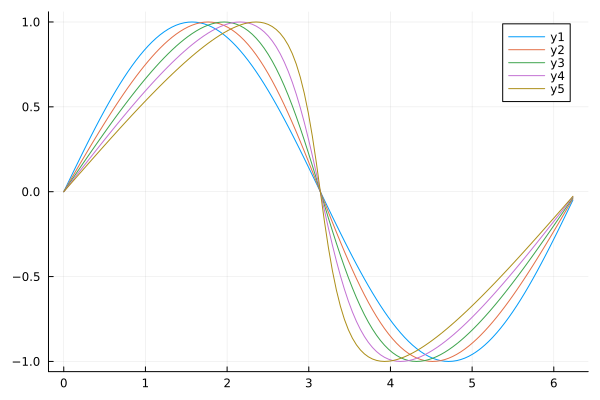

In [7]:
Δt = Δx
p = plot(x, y)
for t in 1:16
    y = semi_lagrangian(burger, y, Δt)
    t % 4 == 0 && plot!(x, y)
end
display(p)

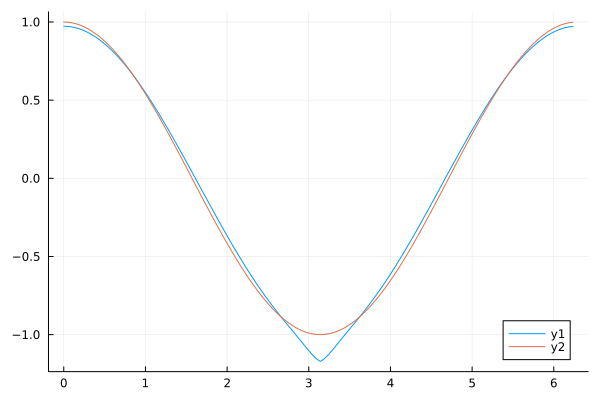

In [15]:
d = ForwardDiff.derivative(0.) do r
    semi_lagrangian(burger::burger_app, y + Ψ[:,2]*r, Δt)
end
plot(x, d)
plot!(x, Ψ[:,2])

In [18]:
y_new .= y
Ψ_new = deepcopy(Ψ)
result = DiffResults.DiffResult(y_new, Ψ_new)
perturb = r -> semi_lagrangian(burger, y_new + Ψ_new*r, Δt)
result = ForwardDiff.jacobian!(result, perturb, zeros(rank))
result.derivs[1]

128×2 Matrix{Float64}:
  0.0        0.972964
  0.0464145  0.971825
  0.092723   0.968492
  0.138822   0.962966
  0.184609   0.955257
  0.229982   0.945383
  0.274839   0.933365
  0.319081   0.91923
  0.362607   0.903009
  0.405322   0.884737
  ⋮          
 -0.405322   0.884737
 -0.362607   0.903009
 -0.319081   0.91923
 -0.274839   0.933365
 -0.229982   0.945383
 -0.184609   0.955257
 -0.138822   0.962966
 -0.092723   0.968492
 -0.0464145  0.971825

In [23]:
result.value

128-element Vector{Float64}:
  0.0
  0.026305097187534692
  0.05259329869932172
  0.07885619383820312
  0.10508529976735607
  0.13127203666345083
  0.15740770215160033
  0.18348344482192838
  0.20949023661442787
  0.2354188438422956
  ⋮
 -0.23541884384229567
 -0.20949023661442762
 -0.18348344482192908
 -0.15740770215160016
 -0.13127203666344994
 -0.10508529976735441
 -0.07885619383819877
 -0.05259329869931924
 -0.026305097187533568